<a href="https://colab.research.google.com/github/starkjiang/TrAC-Generative-Models/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In this tutorial, we will implement an Autoencoder model and then train on two synthetic datasets, one univariate and another multi-variate for anomaly detection (AD) tasks. Essentially, the AD relies on the difference between the original and reconstructed inputs.

# Univariate Timeseries



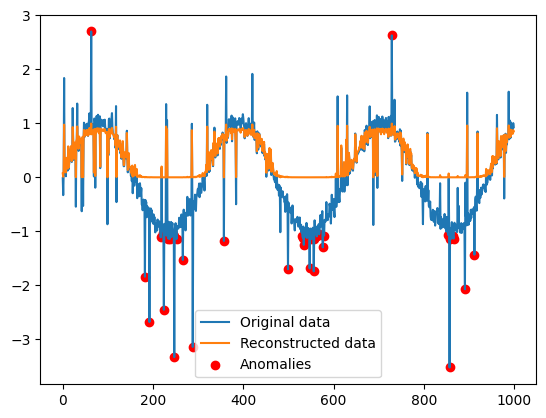

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # If your data is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Generate sample time series data with anomalies
def generate_data(n_samples=1000, anomaly_ratio=0.1):
    data = (np.sin(np.linspace(0, 20, n_samples))
            + np.random.normal(0, 0.1, n_samples))
    anomaly_indices = np.random.choice(
        n_samples,
        int(n_samples * anomaly_ratio),
        replace=False
    )
    data[anomaly_indices] += np.random.normal(
        0, 1, int(n_samples * anomaly_ratio)
    )
    return data

# Create and train the autoencoder
data = generate_data()
data_tensor = torch.tensor(data, dtype=torch.float32).view(-1, 1)

input_size = 1
hidden_size = 16
model = Autoencoder(input_size, hidden_size)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)
    loss.backward()
    optimizer.step()

# Test and plot
with torch.no_grad():
    test_data = generate_data()
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).view(-1, 1)
    reconstructions = model(test_data_tensor)
    errors = torch.abs(reconstructions - test_data_tensor).numpy()

    threshold = np.percentile(errors, 95)  # Set a threshold for AD
    anomalies = np.where(errors > threshold)[0]

    plt.figure()
    plt.plot(test_data, label='Original data')
    plt.plot(reconstructions.numpy(), label='Reconstructed data')
    plt.scatter(anomalies, test_data[anomalies], c='r', label='Anomalies')
    plt.legend()
    plt.show()

# Multivariate Timeseries

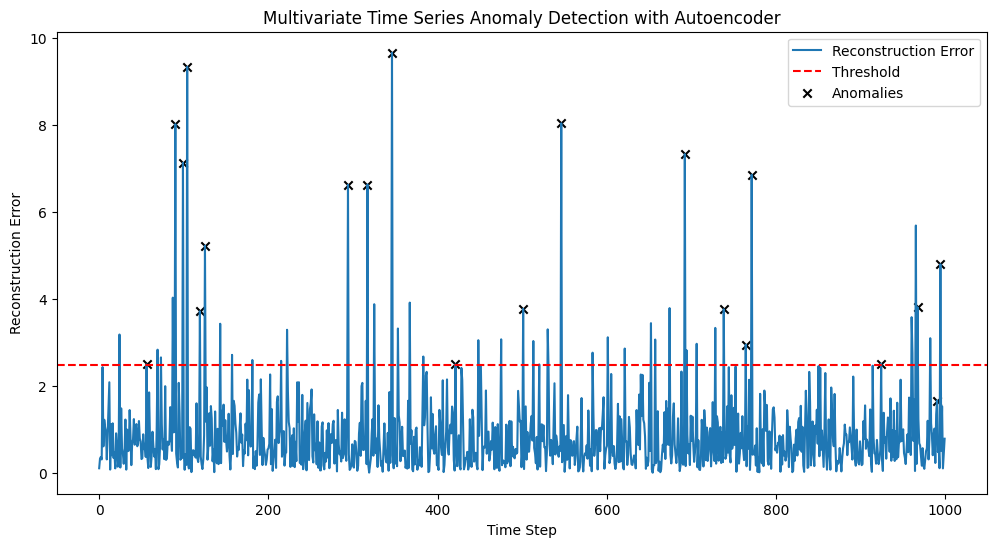

In [13]:
# Generate sample multivariate time series data
np.random.seed(42)
time_steps = 1000
num_features = 3
data = np.random.randn(time_steps, num_features)

# Introduce anomalies
anomaly_indices = np.random.choice(time_steps, size=20, replace=False)
data[anomaly_indices] += 3

# Convert to PyTorch tensors
data_tensor = torch.tensor(data, dtype=torch.float32)

# Create and train the autoencoder
input_dim = data.shape[1]
hidden_dim = 10
model = Autoencoder(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

for epoch in range(300):
    optimizer.zero_grad()
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)
    loss.backward()
    optimizer.step()

# Calculate reconstruction errors
reconstruction_errors = torch.mean(
    (data_tensor - outputs) ** 2, dim=1).detach().numpy()

# Set threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(
    anomaly_indices,
    reconstruction_errors[anomaly_indices],
    color='k',
    marker='x',
    label='Anomalies'
)
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.title('Multivariate Time Series Anomaly Detection with Autoencoder')
plt.show()